# This exercise will focus on training a neural network classifier for the MNIST dataset.

1.   NAME: NITYASH GAUTAM
2.   SID: 862395403
3.   UCR MAIL ID: ngaut006@ucr.edu

## Importing Essentials

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import math
from sklearn.utils import shuffle
from numpy.ma.extras import unique
import time

## Main Assignment Tasks Begin

### **TASK 1**: (2 pts)
Apply Normalization on Training and Test Data


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


label 5


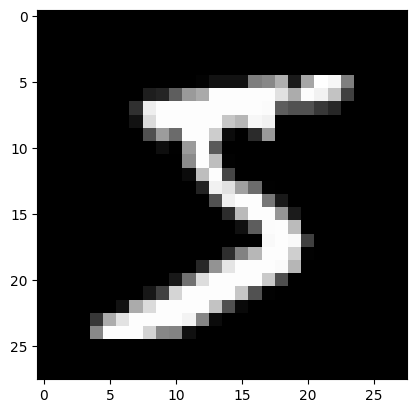

In [4]:
# Visualize 1 sample
print ('label', y_train[0])
plt.imshow(x_train[0], cmap='gray')

#### **Input**: Each input is a 28 x 28 matri. Apply the following operations to obtain d = 785 dimensional input features 

##### Convert Inputs **x** to vectors of size $28^2$ = 784

In [5]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [6]:
print("Train Data Shape = ", x_train.shape)
print("Test Data Shape = ", x_test.shape)

Train Data Shape =  (60000, 784)
Test Data Shape =  (10000, 784)


##### Standardize input images using *z-normalization*: Scale each image *i* $(1≤i≤N)$ to have zero mean and unit variance. In Python Terms, this corresponds to the operation $x => \frac{x-np.mean(x)}{np.std(x)}$.

In [7]:
x_train = (x_train - np.mean(x_train, axis=1, keepdims=True)) / (np.std(x_train, axis=1, keepdims=True) + 1e-8)
x_test = (x_test - np.mean(x_test, axis=1, keepdims=True)) / (np.std(x_test, axis=1, keepdims=True) + 1e-8)

In [8]:
print("Shape of Normalized Train Data = ", x_train.shape)
print("Shape of Normalized Test Data = ", x_test.shape)

Shape of Normalized Train Data =  (60000, 784)
Shape of Normalized Test Data =  (10000, 784)


##### Add bias variable by concatenating 1 to your input. Making the input dimension becomes d = 785.

In [9]:
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

In [10]:
print("Shape of Normalized train data after appending 1 = ", x_train.shape)
print("Shape of Normalized test data after appending 1 = ", x_test.shape)

Shape of Normalized train data after appending 1 =  (60000, 785)
Shape of Normalized test data after appending 1 =  (10000, 785)


#### **Output**: Each label *y* is a digit from 0 to 9. Convert *y* to 0,1 as follows:

$$y -> [ { \frac{0 - 0≤y≤4}{1 - 5≤y≤9}}$$

In [11]:
y_train = (y_train > 4).astype('int')
y_test = (y_test > 4).astype('int')

In [12]:
print(y_train.shape)
print(y_test)

(60000,)
[1 0 0 ... 0 1 1]


##### Final Checks on Data

In [13]:
# Check if the data contains NaN or infinite values
print("Train data contains NaN:", np.any(np.isnan(x_train)))
print("Train data contains infinite values:", np.any(np.isinf(x_train)))
print()
print("Test data contains NaN:", np.any(np.isnan(x_test)))
print("Test data contains infinite values:", np.any(np.isinf(x_test)))
print()

# Check if the labels are correctly assigned
print("Unique train labels:", np.unique(y_train))
print("Unique test labels:", np.unique(y_test))
print()

# Check the shapes of the data and labels
print("Train data shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print()
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Train data contains NaN: False
Train data contains infinite values: False

Test data contains NaN: False
Test data contains infinite values: False

Unique train labels: [0 1]
Unique test labels: [0 1]

Train data shape: (60000, 785)
Train labels shape: (60000,)

Test data shape: (10000, 785)
Test labels shape: (10000,)


### **TASK 2**: (2 pts)
As a baseline, train a linear classifier $ŷ = v^Tx$ and quadratic loss. Report its test accuracy

#### Helper Functions

In [14]:
def convert_to_one_hot(labels):
    """
    Convert an array of labels into a one-hot encoded array.

    Input:
      ndarray): Array of labels to be converted to one-hot encoding.

    Returns:
      numpy.ndarray: One-hot encoded array of labels.
    """
    unique = np.unique(labels) # Get the unique labels
    onehot = np.zeros((labels.shape[0], unique.shape[0])) # Create an array of zeros with dimensions same as labels
    onehot[np.arange(labels.shape[0]), labels] = 1 # Set the corresponding position of each label in onehot array to 1
    return onehot # Return the one-hot encoded array

In [15]:
def accuracy(y_true, onehot_y_out):
    """
    Calculate the accuracy of a classifier's predictions.

    Input:
      y_true (numpy.ndarray): Array of true labels.
      onehot_y_out (numpy.ndarray): One-hot encoded array of predicted labels.

    Returns:
      float: Accuracy of the classifier's predictions.
    """
    predicted_labels = np.argmax(onehot_y_out, axis=1) # Get the predicted labels by finding the index of the max value in each row
    correct_predictions = np.sum(predicted_labels == y_true) # Get the number of correct predictions
    accuracy = correct_predictions / y_true.shape[0] # Calculate the accuracy by dividing the number of correct predictions by the total number of predictions
    return accuracy # Return the accuracy as a float


In [16]:
def predict(X, w):
    """
    Make predictions based on the input and weights.

    Input:
      X (numpy.ndarray): Array of input data.
      w (numpy.ndarray): Array of weights.

    Returns:
      numpy.ndarray: Array of predictions.
    """
    predictions = np.matmul(X, w.T) # Calculate the dot product of the input data and the weights transposed
    return predictions # Return the array of predictions


In [17]:
def loss(onehot_y_pred, onehot_y_true):
    """
    Calculate the mean squared error (MSE) loss between predicted and true labels.

    Input:
      onehot_y_pred (numpy.ndarray): One-hot encoded array of predicted labels.
      onehot_y_true (numpy.ndarray): One-hot encoded array of true labels.

    Returns:
      float: Mean squared error (MSE) loss between predicted and true labels.
    """
    diff = onehot_y_pred - onehot_y_true # Calculate the difference between the predicted and true labels
    squared_diff = diff**2 # Square the difference
    mean_squared_diff = np.sum(squared_diff)/(2*onehot_y_pred.shape[0]) # Calculate the mean squared difference
    return mean_squared_diff # Return the mean squared error loss as a float


In [18]:
def plot_accuracy(train_accuracy, test_accuracy):
    plt.figure(2)
    plt.plot(np.arange(0,len(train_accuracy)), train_accuracy, label='Train Accuracy')
    plt.plot(np.arange(0,len(test_accuracy)), test_accuracy, label='Test Accuracy')
    plt.title('Plot of ACCURACY vs ITERATIONS')
    plt.xlabel('ITERATIONS')
    plt.ylabel('ACCURACY')
    plt.legend()
    plt.grid()
    plt.show()

#### Main Function

In [19]:
def linear_model(x_train, y_train_true, y_train_oh, x_test, y_test_true, y_test_oh, lr=0.001, n_epochs=50, batch_size=10):
    """
    Train a linear model on the training set and evaluate it on the test set.

    Input:
      x_train (numpy.ndarray): Array of training data.
      y_train_true (numpy.ndarray): Array of true training labels.
      y_train_oh (numpy.ndarray): One-hot encoded array of training labels.
      x_test (numpy.ndarray): Array of test data.
      y_test_true (numpy.ndarray): Array of true test labels.
      y_test_oh (numpy.ndarray): One-hot encoded array of test labels.
      lr (float): Learning rate (default=0.001).
      n_epochs (int): Number of training epochs (default=50).
      batch_size (int): Batch size for training (default=10).

    Returns:
      - numpy.ndarray: Array of weights learned during training.
      - numpy.ndarray: Array of training losses.
      - numpy.ndarray: Array of training accuracies.
      - numpy.ndarray: Array of test accuracies.
    """
    # Initialize weights
    input_dim_linear = x_train.shape[1]
    output_dim_linear = y_train_oh.shape[1]
    weights_linear = np.zeros((output_dim_linear, input_dim_linear))

    # Initialize arrays to store training progress
    loss_array_linear = []
    train_accuracy_array_linear = []
    test_accuracy_array_linear = []

    for epoch in range(n_epochs):
        # Shuffle data for each epoch
        shuff_idx = np.random.permutation(x_train.shape[0])
        x_shuffled_linear = x_train[shuff_idx]
        onehot_y_shuffled_linear = y_train_oh[shuff_idx]

        # Update weights in batches
        i = 0
        while i < x_train.shape[0]:
            x = x_shuffled_linear[i:i + batch_size]
            y = onehot_y_shuffled_linear[i:i + batch_size]

            out = predict(x, weights_linear)
            l_linear = loss(out, y)
            w_grad = np.matmul((out - y).T, x) / out.shape[0]
            weights_linear -= lr * w_grad

            i += batch_size

        # Calculate training and test accuracy for this epoch
        loss_array_linear.append(l_linear)
        train_acc = accuracy(y_train_true, predict(x_train, weights_linear))
        train_accuracy_array_linear.append(train_acc)
        test_acc = accuracy(y_test_true, predict(x_test, weights_linear))
        test_accuracy_array_linear.append(test_acc)

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'epoch = {epoch+1}, Training Loss = {l_linear}, Training Accuracy = {train_acc}, Test Accuracy = {test_acc}')

    return weights_linear, loss_array_linear, train_accuracy_array_linear, test_accuracy_array_linear


In [20]:
# convert y to one hot encoded
onehot_y_train_linear = convert_to_one_hot(y_train)
onehot_y_test_linear = convert_to_one_hot(y_test)

#### Testing The Linear Classifier

In [21]:
w,loss_arr,train_acc, test_acc = linear_model(x_train, y_train, onehot_y_train_linear,x_test, y_test, onehot_y_test_linear)

epoch = 10, Training Loss = 0.2036670118883681, Training Accuracy = 0.8619666666666667, Test Accuracy = 0.8616
epoch = 20, Training Loss = 0.08219161142693039, Training Accuracy = 0.8649666666666667, Test Accuracy = 0.8648
epoch = 30, Training Loss = 0.11797171389724433, Training Accuracy = 0.8640333333333333, Test Accuracy = 0.8637
epoch = 40, Training Loss = 0.05368406003047066, Training Accuracy = 0.8647833333333333, Test Accuracy = 0.8623
epoch = 50, Training Loss = 0.10038875869377213, Training Accuracy = 0.8643833333333333, Test Accuracy = 0.8635


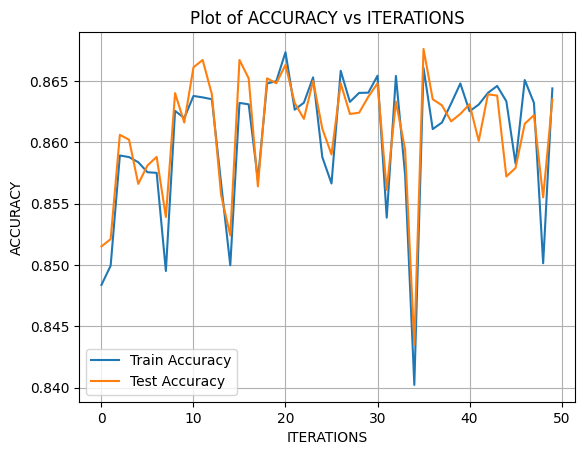

In [22]:
plot_accuracy(train_acc, test_acc)

In [23]:
print ("The test accuracy is {}%".format(test_acc[-1] * 100))

The test accuracy is 86.35000000000001%


### **TASK 3**: (7 pts)
Train a neural network classifier with quadratic loss ℓ(y, f(x)) = (y − f(x))2. Plot the progress of the test and training accuracy (y-axis) as a function of the iteration counter t (x-axis)2. Report the final test accuracy for the following choices:
 * k = 5
 * k = 40
 * k = 200
 * Comment on the role of hidden units k on the ease of optimization and accuracy.


#### Helper Functions

In [24]:
def quadratic_loss(y_true, y_pred):
    """
    Calculate the mean quadratic loss between predicted and true values.

    Input:
      y_true (numpy.ndarray): Array of true values.
      y_pred (numpy.ndarray): Array of predicted values.

    Returns:
      float: The mean quadratic loss between predicted and true values.
    """
    return np.mean((y_true - y_pred)**2)

In [25]:
def relu(x):
    """
    Rectified Linear Unit (ReLU) activation function.

    Input:
      input (numpy.ndarray): Array of input values.

    Returns:
      numpy.ndarray: Array of values resulting from applying ReLU.
    """
    return np.maximum(x, 0)

In [26]:
def relu_deriv(x):
    """
    Derivative of the Rectified Linear Unit (ReLU) activation function.

    Input:
      input (numpy.ndarray): Array of input values.

    Returns:
      numpy.ndarray: Array of values resulting from applying the ReLU derivative.
    """
    return np.where(x > 0, 1, 0)

In [27]:
def get_accuracy_ql(true_y, pred_y):
    """
    Calculate accuracy of predicted values using quadratic loss.

    Input:
      y_true (numpy.ndarray): Array of true values.
      y_pred (numpy.ndarray): Array of predicted values.

    Returns:
      float: The accuracy of predicted values using quadratic loss.
    """
    pred_y = pred_y.reshape(-1,)
    pred_y = np.where(pred_y > 0, 1, 0)

    return np.sum(true_y == pred_y)/true_y.shape[0]

#### Main Function

In [28]:
def shallow_neural_quadratic(x_train, x_test, y_train, y_test, lr=0.001, k=5, epochs=10, batch_size=10):
    """
    This function trains a shallow neural network with a quadratic layer and calculates training and testing accuracy.
    
    Input:
      x_train (numpy array): Training input data.
      x_test (numpy array): Testing input data.
      y_train (numpy array): Training output data.
      y_test (numpy array): Testing output data.
      lr (float, optional): Learning rate. Default is 0.01.
      k (int, optional): Number of hidden units. Default is 5.
      epochs (int, optional): Number of training epochs. Default is 10.
      batch_size (int, optional): Size of the mini-batch. Default is 10.

    Returns:
      A tuple containing two lists (train_acc_per_iteration_qd, test_acc_per_iteration_qd) with the training and testing accuracy per iteration.
    """

    # Set random seed for reproducibility
    np.random.seed(112233)

    # Initialize weights for the quadratic layer
    w_qd = np.random.randn(k, x_train.shape[1]) / x_train.shape[1]
    v_qd = np.random.randn(k) / k

    # Initialize lists to store training and testing accuracy per iteration
    train_acc_per_iteration_qd = []
    test_acc_per_iteration_qd = []

    # Initialize iteration counter
    iter_ctr_qd = 0

    # Start training loop
    for epoch in range(epochs):

        # Shuffle the training data
        shuffled_indices = np.random.permutation(x_train.shape[0])
        x_shuffled = x_train[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]

        i = 0

        # Process the data in mini-batches
        while i < x_train.shape[0]:

            # Get the current mini-batch
            x = x_shuffled[i:i+batch_size]
            y = y_shuffled[i:i+batch_size]

            # Perform forward pass
            z1 = np.matmul(x, w_qd.T)
            y1 = relu(z1)
            z2 = np.matmul(y1, v_qd)
            y2 = np.round(z2)

            # Calculate error
            delta_2 = 2*(y2 - y)

            # Calculate weight update for output layer
            dv = np.matmul(y1.T, delta_2) / x.shape[0]

            # Calculate weight update for hidden layer
            relu_derivative = relu_deriv(z1)
            delta_1 = np.matmul(delta_2.reshape(-1,1), v_qd.reshape(-1,1).T) * relu_derivative
            dw = np.matmul(delta_1.T, x) / x.shape[0]

            # Update weights
            w_qd -= lr*dw
            v_qd -= lr*dv

            # Increment mini-batch counter
            i += batch_size

            # Calculate training and testing accuracy every 10000 iterations or at the start
            if iter_ctr_qd == 0 or iter_ctr_qd % 100 == 0:
              z1 = np.matmul(x_train, w_qd.T)
              y1 = relu(z1)
              z2 = np.matmul(y1, v_qd)
              y2 = np.round(z2)
              train_accuracy_ql = get_accuracy_ql(y_train, y2)

              z1 = np.matmul(x_test, w_qd.T)
              y1 = relu(z1)
              z2 = np.matmul(y1, v_qd)
              y2 = np.round(z2)
              test_accuracy_ql = get_accuracy_ql(y_test, y2)

              # Append training and testing accuracy to their respective lists
              train_acc_per_iteration_qd.append((iter_ctr_qd, train_accuracy_ql))
              test_acc_per_iteration_qd.append((iter_ctr_qd, test_accuracy_ql))

            # Increment iteration counter
            iter_ctr_qd += 1

        # Print training and testing accuracy for the current epoch
        print('For the EPOCH:', epoch + 1, ' Training Accuracy =', train_accuracy_ql, ' Testing Accuracy =', test_accuracy_ql)

    # Return training and testing accuracy per iteration
    return train_acc_per_iteration_qd, test_acc_per_iteration_qd

#### Testing the Shallow Net with Quadratic Loss



> For k = 5



In [29]:
print('For K = 5')

print()

# Call the function to train a shallow neural network with quadratic loss on the input data
train_acc_per_iteration_ql, test_acc_per_iteration_ql = shallow_neural_quadratic(x_train, x_test, y_train, y_test, lr=0.001, k=5, epochs=10, batch_size=10)

# Convert the lists of training and testing accuracies to numpy arrays
train_acc_per_iteration_ql = np.array(train_acc_per_iteration_ql)
test_acc_per_iteration_ql = np.array(test_acc_per_iteration_ql)

For K = 5

For the EPOCH: 1  Training Accuracy = 0.7990666666666667  Testing Accuracy = 0.8052
For the EPOCH: 2  Training Accuracy = 0.8086333333333333  Testing Accuracy = 0.8135
For the EPOCH: 3  Training Accuracy = 0.81995  Testing Accuracy = 0.8254
For the EPOCH: 4  Training Accuracy = 0.8264333333333334  Testing Accuracy = 0.8221
For the EPOCH: 5  Training Accuracy = 0.8308  Testing Accuracy = 0.833
For the EPOCH: 6  Training Accuracy = 0.8583833333333334  Testing Accuracy = 0.8658
For the EPOCH: 7  Training Accuracy = 0.8885  Testing Accuracy = 0.8847
For the EPOCH: 8  Training Accuracy = 0.9076833333333333  Testing Accuracy = 0.9083
For the EPOCH: 9  Training Accuracy = 0.9076833333333333  Testing Accuracy = 0.9038
For the EPOCH: 10  Training Accuracy = 0.90725  Testing Accuracy = 0.9083


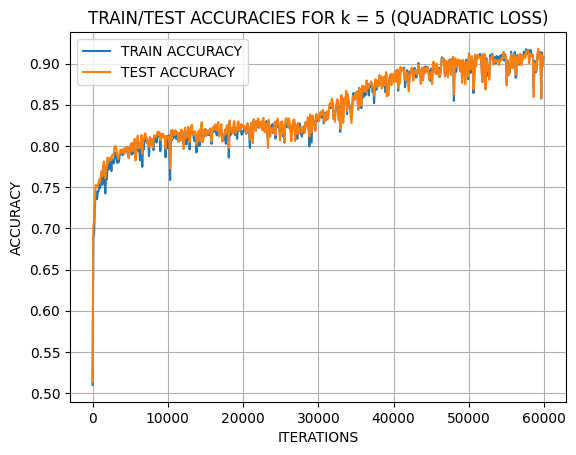

In [30]:
# Plot the training and testing accuracies as a function of training iterations
plt.figure(1)
plt.plot(train_acc_per_iteration_ql[:, 0], train_acc_per_iteration_ql[:, 1], label='TRAIN ACCURACY')
plt.plot(test_acc_per_iteration_ql[:, 0], test_acc_per_iteration_ql[:,1], label='TEST ACCURACY')
plt.title('TRAIN/TEST ACCURACIES FOR k = 5 (QUADRATIC LOSS)')
plt.xlabel('ITERATIONS')
plt.ylabel('ACCURACY')
plt.legend()
plt.grid()
plt.show()

In [31]:
# Print the final testing accuracy achieved by the network
acc_5_ql = test_acc_per_iteration_ql[-1:,1]
print(f'Test Accuracy = {acc_5_ql*100} %')

Test Accuracy = [90.83] %




> For k = 40



In [32]:
print('For K = 40')

print()

# Call the function to train a shallow neural network with quadratic loss on the input data
train_acc_per_iteration_ql, test_acc_per_iteration_ql = shallow_neural_quadratic(x_train, x_test, y_train, y_test, lr=0.001, k=40, epochs=10, batch_size=10)

# Convert the lists of training and testing accuracies to numpy arrays
train_acc_per_iteration_ql = np.array(train_acc_per_iteration_ql)
test_acc_per_iteration_ql = np.array(test_acc_per_iteration_ql)

For K = 40

For the EPOCH: 1  Training Accuracy = 0.8135666666666667  Testing Accuracy = 0.8132
For the EPOCH: 2  Training Accuracy = 0.8756166666666667  Testing Accuracy = 0.8848
For the EPOCH: 3  Training Accuracy = 0.91705  Testing Accuracy = 0.9175
For the EPOCH: 4  Training Accuracy = 0.9333166666666667  Testing Accuracy = 0.9328
For the EPOCH: 5  Training Accuracy = 0.9381166666666667  Testing Accuracy = 0.9365
For the EPOCH: 6  Training Accuracy = 0.9500833333333333  Testing Accuracy = 0.9437
For the EPOCH: 7  Training Accuracy = 0.9534833333333333  Testing Accuracy = 0.9447
For the EPOCH: 8  Training Accuracy = 0.9527833333333333  Testing Accuracy = 0.9465
For the EPOCH: 9  Training Accuracy = 0.9578166666666666  Testing Accuracy = 0.9529
For the EPOCH: 10  Training Accuracy = 0.9606833333333333  Testing Accuracy = 0.9514


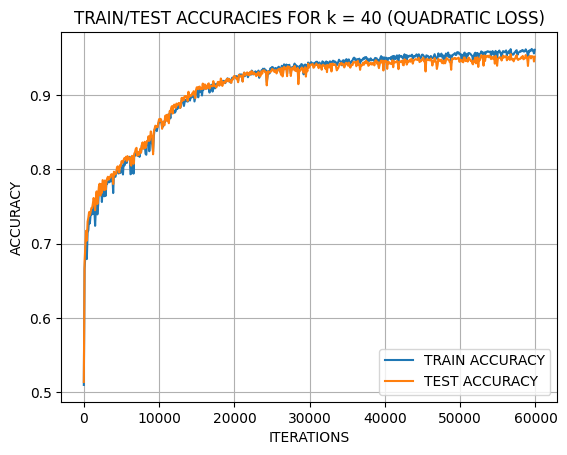

In [33]:
# Plot the training and testing accuracies as a function of training iterations
plt.figure(1)
plt.plot(train_acc_per_iteration_ql[:, 0], train_acc_per_iteration_ql[:, 1], label='TRAIN ACCURACY')
plt.plot(test_acc_per_iteration_ql[:, 0], test_acc_per_iteration_ql[:,1], label='TEST ACCURACY')
plt.title('TRAIN/TEST ACCURACIES FOR k = 40 (QUADRATIC LOSS)')
plt.xlabel('ITERATIONS')
plt.ylabel('ACCURACY')
plt.legend()
plt.grid()
plt.show()

In [34]:
# Print the final testing accuracy achieved by the network
acc_40_ql = test_acc_per_iteration_ql[-1:,1]
print(f'Test Accuracy = {acc_40_ql*100}%')

Test Accuracy = [95.14]%




> For k = 200



In [35]:
print('For K = 200')

print()

# Call the function to train a shallow neural network with quadratic loss on the input data
train_acc_per_iteration_ql, test_acc_per_iteration_ql = shallow_neural_quadratic(x_train, x_test, y_train, y_test, lr=0.001, k=200, epochs=10, batch_size=10)

# Convert the lists of training and testing accuracies to numpy arrays
train_acc_per_iteration_ql = np.array(train_acc_per_iteration_ql)
test_acc_per_iteration_ql = np.array(test_acc_per_iteration_ql)

For K = 200

For the EPOCH: 1  Training Accuracy = 0.8229833333333333  Testing Accuracy = 0.8257
For the EPOCH: 2  Training Accuracy = 0.9058166666666667  Testing Accuracy = 0.9106
For the EPOCH: 3  Training Accuracy = 0.9324833333333333  Testing Accuracy = 0.9309
For the EPOCH: 4  Training Accuracy = 0.9474333333333333  Testing Accuracy = 0.9434
For the EPOCH: 5  Training Accuracy = 0.9572333333333334  Testing Accuracy = 0.9527
For the EPOCH: 6  Training Accuracy = 0.9609666666666666  Testing Accuracy = 0.9538
For the EPOCH: 7  Training Accuracy = 0.9579166666666666  Testing Accuracy = 0.9478
For the EPOCH: 8  Training Accuracy = 0.9698333333333333  Testing Accuracy = 0.9609
For the EPOCH: 9  Training Accuracy = 0.9695666666666667  Testing Accuracy = 0.9568
For the EPOCH: 10  Training Accuracy = 0.9731666666666666  Testing Accuracy = 0.9608


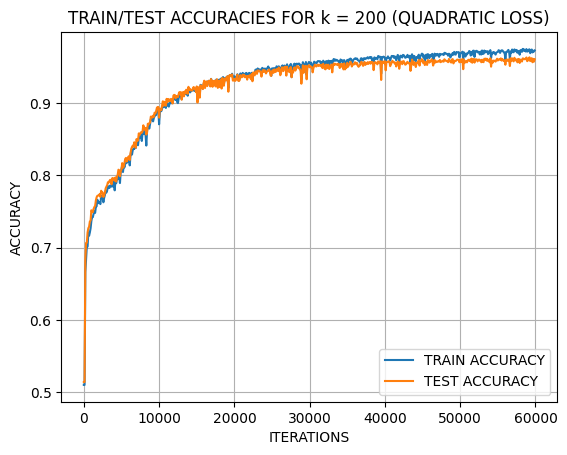

In [36]:
# Plot the training and testing accuracies as a function of training iterations
plt.figure(1)
plt.plot(train_acc_per_iteration_ql[:, 0], train_acc_per_iteration_ql[:, 1], label='TRAIN ACCURACY')
plt.plot(test_acc_per_iteration_ql[:, 0], test_acc_per_iteration_ql[:,1], label='TEST ACCURACY')
plt.title('TRAIN/TEST ACCURACIES FOR k = 200 (QUADRATIC LOSS)')
plt.xlabel('ITERATIONS')
plt.ylabel('ACCURACY')
plt.legend()
plt.grid()
plt.show()

In [37]:
# Print the final testing accuracy achieved by the network
acc_200_ql = test_acc_per_iteration_ql[-1:,1]
print(f'Test Accuracy = {acc_200_ql*100}%')

Test Accuracy = [96.08]%


#### Comment on the role of hidden units k on the ease of optimization and accuracy.

*The number of Hidden Units allow the neural net to model the complex and non linear relationships between the inputs and outputs.*

*In this case as we observe, as k increases, the ease of optimization decreases due to the increase in number of hidden layer parameters. But the accuracy increases to some extent. It is to be noted that too much increase in k can also result in model overfitting*

### **TASK 4**: (7 pts)
Train a neural network classifier with logistic loss, namely $ℓ(y, f(x)) = −y log(σ(f(x))) − (1 −y) log(1 − σ(f(x)))$ where $σ(x) = 1/(1 + e−x)$ is the sigmoid function. Repeat step 3.


#### Helper Functions

In [38]:
def sigmoid(z):
    """
    Apply the sigmoid function to the input.

    Input:
      z (numpy.ndarray): Input data.

    Returns:
      Output of applying the sigmoid function to the input.
    """
    # Apply the sigmoid function to the input and return the output
    return 1 / (1 + np.exp(-z))

In [39]:
def logistic_loss(y_true, y_pred):
    """
    Compute the logistic loss between the true labels and predicted probabilities.

    Input:
      y_true (numpy.ndarray): True labels.
      y_pred (numpy.ndarray): Predicted probabilities.

    Returns:
      Value of the logistic loss between the true labels and predicted probabilities.
    """
    # Initialize a variable to accumulate the logistic loss
    cumulative_l = 0

    # Reshape the predicted probabilities array to be 1-dimensional
    y_pred = y_pred.reshape(-1,)

    # Compute the logistic loss for each pair of true label and predicted probability
    for y, y_hat in zip(y_true, y_pred):
        # Compute the sigmoid function of the predicted probability
        sigmoid_y_hat = sigmoid(y_hat)

        # Compute the logistic loss for the current pair of true label and predicted probability
        l = (y * np.log(sigmoid_y_hat)) + ((1 - y) * np.log(1 - sigmoid_y_hat))
        l = -l

        # Add the logistic loss to the cumulative loss
        cumulative_l += l

    # Compute the average logistic loss across all the pairs of true label and predicted probability
    return cumulative_l / y_true.shape[0]

In [40]:
def get_accuracy_ll(y_true, y_pred):
    """
    Compute the accuracy between the true labels and predicted probabilities.

    Input:
      y_true (numpy.ndarray): True labels.
      y_pred (numpy.ndarray): Predicted probabilities.

    Returns:
      float: Accuracy between the true labels and predicted probabilities.
    """
    # Reshape the predicted probabilities array to be 1-dimensional
    y_pred = y_pred.reshape(-1,)

    # Convert the predicted probabilities to binary values based on a threshold of 0.5
    y_pred = np.where(y_pred > 0, 1, 0)

    # Compute the accuracy between the true labels and predicted binary values
    return np.sum(y_true == y_pred) / y_true.shape[0]

#### Main Function

In [41]:
def shallow_neural_logistic(x_train, x_test, y_train, y_test, lr=0.001, k=5, epochs=10, batch_size=10):
    """
    This function trains a shallow neural network with a logistic layer and calculates training and testing accuracy.
    
    Input:
      x_train (numpy array): Training input data.
      x_test (numpy array): Testing input data.
      y_train (numpy array): Training output data.
      y_test (numpy array): Testing output data.
      lr (float, optional): Learning rate. Default is 0.01.
      k (int, optional): Number of hidden units. Default is 5.
      epochs (int, optional): Number of training epochs. Default is 10.
      batch_size (int, optional): Size of the mini-batch. Default is 10.

    Returns:
      A tuple containing two lists (train_acc_per_iteration_log, test_acc_per_iteration_log) with the training and testing accuracy per iteration.
    """

    # Set random seed for reproducibility
    np.random.seed(112233)

    # Initialize weights for the logistic layer
    w_log = np.random.randn(k, x_train.shape[1]) / x_train.shape[1]
    v_log = np.random.randn(k) / k

    # Initialize lists to store training and testing accuracy per iteration
    train_acc_per_iteration_log = []
    test_acc_per_iteration_log = []

    # Initialize iteration counter
    iter_ctr_log = 0

    # Start training loop
    for epoch in range(epochs):

        # Shuffle the training data
        shuffled_indices = np.random.permutation(x_train.shape[0])
        x_shuffled = x_train[shuffled_indices]
        y_shuffled = y_train[shuffled_indices]

        i = 0

        # Process the data in mini-batches
        while i < x_train.shape[0]:

            # Get the current mini-batch
            x = x_shuffled[i:i+batch_size]
            y = y_shuffled[i:i+batch_size]

            # Perform forward pass
            z1 = np.matmul(x, w_log.T)
            y1 = relu(z1)
            z2 = np.matmul(y1, v_log)
            y2 = np.round(z2)

            # Calculate error
            delta_2 = (y2 - y)

            # Calculate weight update for output layer
            dv = np.matmul(y1.T, delta_2) / x.shape[0]

            # Calculate weight update for hidden layer
            relu_derivative = relu_deriv(z1)
            delta_1 = np.matmul(delta_2.reshape(-1,1), v_log.reshape(-1,1).T) * relu_derivative
            dw = np.matmul(delta_1.T, x) / x.shape[0]

            # Update weights
            w_log -= lr*dw
            v_log -= lr*dv

            # Increment mini-batch counter
            i += batch_size

            # Calculate training and testing accuracy every 10000 iterations or at the start
            if iter_ctr_log == 0 or iter_ctr_log % 100 == 0:
              z1 = np.matmul(x_train, w_log.T)
              y1 = relu(z1)
              z2 = np.matmul(y1, v_log)
              y2 = np.round(z2)
              train_accuracy_log = get_accuracy_ql(y_train, y2)

              z1 = np.matmul(x_test, w_log.T)
              y1 = relu(z1)
              z2 = np.matmul(y1, v_log)
              y2 = np.round(z2)
              test_accuracy_log = get_accuracy_ql(y_test, y2)

              # Append training and testing accuracy to their respective lists
              train_acc_per_iteration_log.append((iter_ctr_log, train_accuracy_log))
              test_acc_per_iteration_log.append((iter_ctr_log, test_accuracy_log))

            # Increment iteration counter
            iter_ctr_log += 1

        # Print training and testing accuracy for the current epoch
        print('For the EPOCH:', epoch + 1, ' Training Accuracy =', train_accuracy_log, ' Testing Accuracy =', test_accuracy_log)

    # Return training and testing accuracy per iteration
    return train_acc_per_iteration_log, test_acc_per_iteration_log

#### Testing the Shallow Net with Logistic Loss



> For k = 5



In [42]:
print ('For K = 5')

print()

# Call the function to train a shallow neural network with Logistic loss on the input data
train_acc_per_iteration_ll, test_acc_per_iteration_ll = shallow_neural_logistic(x_train, x_test, y_train, y_test, lr=0.001, k=5, epochs=10, batch_size=10)

# Convert the lists of training and testing accuracies to numpy arrays
train_acc_per_iteration_ll = np.array(train_acc_per_iteration_ll)
test_acc_per_iteration_ll = np.array(test_acc_per_iteration_ll)

For K = 5

For the EPOCH: 1  Training Accuracy = 0.7866833333333333  Testing Accuracy = 0.791
For the EPOCH: 2  Training Accuracy = 0.8036  Testing Accuracy = 0.8081
For the EPOCH: 3  Training Accuracy = 0.8108  Testing Accuracy = 0.8152
For the EPOCH: 4  Training Accuracy = 0.8183166666666667  Testing Accuracy = 0.8157
For the EPOCH: 5  Training Accuracy = 0.81465  Testing Accuracy = 0.819
For the EPOCH: 6  Training Accuracy = 0.8192  Testing Accuracy = 0.8253
For the EPOCH: 7  Training Accuracy = 0.8078  Testing Accuracy = 0.8051
For the EPOCH: 8  Training Accuracy = 0.84595  Testing Accuracy = 0.8428
For the EPOCH: 9  Training Accuracy = 0.8491666666666666  Testing Accuracy = 0.8462
For the EPOCH: 10  Training Accuracy = 0.8690666666666667  Testing Accuracy = 0.8718


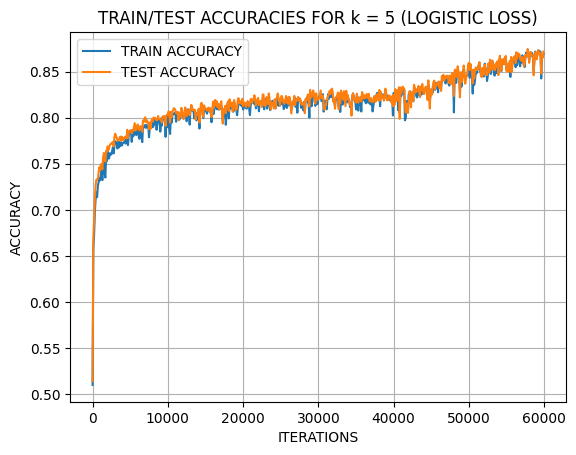

In [43]:
# Plot the training and testing accuracies as a function of training iterations
plt.figure(1)
plt.plot(train_acc_per_iteration_ll[:, 0], train_acc_per_iteration_ll[:, 1], label='TRAIN ACCURACY')
plt.plot(test_acc_per_iteration_ll[:, 0], test_acc_per_iteration_ll[:,1], label='TEST ACCURACY')
plt.title('TRAIN/TEST ACCURACIES FOR k = 5 (LOGISTIC LOSS)')
plt.xlabel('ITERATIONS')
plt.ylabel('ACCURACY')
plt.legend()
plt.grid()
plt.show()

In [44]:
# Print the final testing accuracy achieved by the network
acc_5_ql = test_acc_per_iteration_ll[-1:,1]
print(f'Test Accuracy = {acc_5_ql*100}%')

Test Accuracy = [87.18]%




> For k = 40



In [45]:
print ('For K = 40')

print()
# Call the function to train a shallow neural network with Logistic loss on the input data
train_acc_per_iteration_ll, test_acc_per_iteration_ll = shallow_neural_logistic(x_train, x_test, y_train, y_test, lr=0.001, k=40, epochs=10, batch_size=10)

# Convert the lists of training and testing accuracies to numpy arrays
train_acc_per_iteration_ll = np.array(train_acc_per_iteration_ll)
test_acc_per_iteration_ll = np.array(test_acc_per_iteration_ll)

For K = 40

For the EPOCH: 1  Training Accuracy = 0.7877333333333333  Testing Accuracy = 0.7933
For the EPOCH: 2  Training Accuracy = 0.8019333333333334  Testing Accuracy = 0.8104
For the EPOCH: 3  Training Accuracy = 0.8462333333333333  Testing Accuracy = 0.8509
For the EPOCH: 4  Training Accuracy = 0.8810833333333333  Testing Accuracy = 0.8864
For the EPOCH: 5  Training Accuracy = 0.8964166666666666  Testing Accuracy = 0.9013
For the EPOCH: 6  Training Accuracy = 0.9188666666666667  Testing Accuracy = 0.9185
For the EPOCH: 7  Training Accuracy = 0.9294833333333333  Testing Accuracy = 0.9258
For the EPOCH: 8  Training Accuracy = 0.9337  Testing Accuracy = 0.933
For the EPOCH: 9  Training Accuracy = 0.9406333333333333  Testing Accuracy = 0.9349
For the EPOCH: 10  Training Accuracy = 0.9442  Testing Accuracy = 0.939


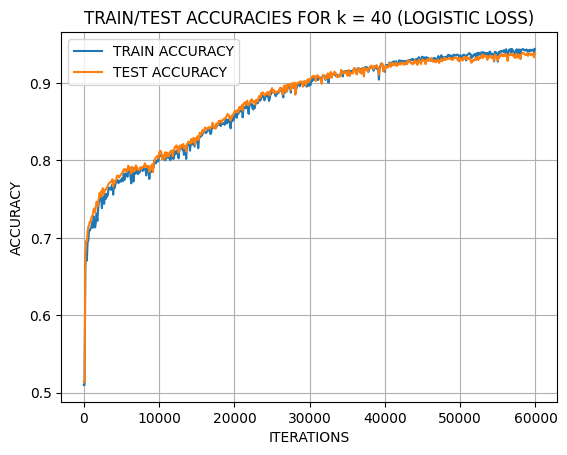

In [46]:
# Plot the training and testing accuracies as a function of training iterations
plt.figure(1)
plt.plot(train_acc_per_iteration_ll[:, 0], train_acc_per_iteration_ll[:, 1], label='TRAIN ACCURACY')
plt.plot(test_acc_per_iteration_ll[:, 0], test_acc_per_iteration_ll[:,1], label='TEST ACCURACY')
plt.title('TRAIN/TEST ACCURACIES FOR k = 40 (LOGISTIC LOSS)')
plt.xlabel('ITERATIONS')
plt.ylabel('ACCURACY')
plt.legend()
plt.grid()
plt.show()

In [47]:
# Print the final testing accuracy achieved by the network
acc_40_ql = test_acc_per_iteration_ll[-1:,1]
print(f'Test Accuracy = {acc_40_ql*100}%')

Test Accuracy = [93.9]%




> For k = 200



In [48]:
print ('For K = 200')

print()

# Call the function to train a shallow neural network with Logistic loss on the input data
train_acc_per_iteration_ll, test_acc_per_iteration_ll = shallow_neural_logistic(x_train, x_test, y_train, y_test, lr=0.001, k=200, epochs=10, batch_size=10)

# Convert the lists of training and testing accuracies to numpy arrays
train_acc_per_iteration_ll = np.array(train_acc_per_iteration_ll)
test_acc_per_iteration_ll = np.array(test_acc_per_iteration_ll)

For K = 200

For the EPOCH: 1  Training Accuracy = 0.7751666666666667  Testing Accuracy = 0.7782
For the EPOCH: 2  Training Accuracy = 0.82395  Testing Accuracy = 0.8335
For the EPOCH: 3  Training Accuracy = 0.87705  Testing Accuracy = 0.8769
For the EPOCH: 4  Training Accuracy = 0.9082  Testing Accuracy = 0.9118
For the EPOCH: 5  Training Accuracy = 0.9244833333333333  Testing Accuracy = 0.9257
For the EPOCH: 6  Training Accuracy = 0.9339166666666666  Testing Accuracy = 0.934
For the EPOCH: 7  Training Accuracy = 0.9402833333333334  Testing Accuracy = 0.9366
For the EPOCH: 8  Training Accuracy = 0.9506  Testing Accuracy = 0.9473
For the EPOCH: 9  Training Accuracy = 0.9526  Testing Accuracy = 0.9477
For the EPOCH: 10  Training Accuracy = 0.9569333333333333  Testing Accuracy = 0.9526


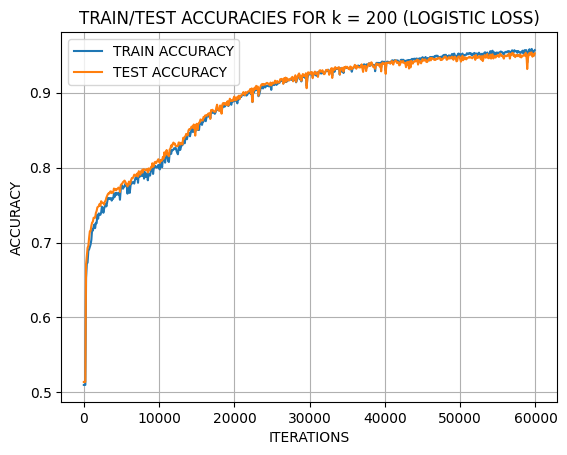

In [49]:
# Plot the training and testing accuracies as a function of training iterations
plt.figure(1)
plt.plot(train_acc_per_iteration_ll[:, 0], train_acc_per_iteration_ll[:, 1], label='TRAIN ACCURACY')
plt.plot(test_acc_per_iteration_ll[:, 0], test_acc_per_iteration_ll[:,1], label='TEST ACCURACY')
plt.title('TRAIN/TEST ACCURACIES FOR k = 200 (LOGISTIC LOSS)')
plt.xlabel('ITERATIONS')
plt.ylabel('ACCURACY')
plt.legend()
plt.grid()
plt.show()

In [50]:
# Print the final testing accuracy achieved by the network
acc_200_ql = test_acc_per_iteration_ll[-1:,1]
print(f'Test Accuracy = {acc_200_ql*100}%')

Test Accuracy = [95.26]%


#### Comment on the role of hidden units k on the ease of optimization and accuracy.

*Similar to the previous case, here also it is observed that, as k increases, the ease of optimization decreases due to the increase in number of hidden layer parameters. But the accuracy increases to some extent.*

### **TASK 5**: (2 pts)
Comment on the difference between linear model and neural net. Comment on the differences between logistic and quadratic loss in terms of optimization and test/train accuracy.


*Linear models are simpler as they have a linear relationship between the inputs and the output making them suitable and a well-performing option for simpler problems. Neural Net on the other hand, is capable enough to handle complex regression/classification problems while giving a better performance than the Linear models even on simpler tasks.*

*Though my implementation somehow did not perform as expected. The neural net with logistic loss should have performed better than the one with quadratic loss in terms if train/test accuracy, as logistic losses are more resistant to outliers and have a smooth surface thereby eliminating the scenarios of multiple local minimas.*

## Submission

In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 340 kB in 1s (254 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages 

In [ ]:
!jupyter nbconvert --log-level CRITICAL --to pdf Nityash_Gautam_Assignment_2.ipynb # make sure the ipynb name is correct